In [2092]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random

In [2093]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [2094]:
class GAwTSP:
    rng = np.random.default_rng()

    def __init__(self, data_path: str, opt_path: str, population_count: int):
        self.data_path = data_path
        self.opt_path = opt_path
        self.population_count = population_count
        self.cities = np.loadtxt(data_path)
        self.city_count = len(self.cities)
        self.cost_matrix = self.make_cost_matrix()
        self.opt_route = np.loadtxt(self.opt_path, dtype=np.int32) - 1
        self.opt_cost = self.id_cost(self.opt_route)
        self.gene_count = self.city_count - 1
        self.generation = self.init_generation()
        self.g_cost = np.ndarray(shape=(self.population_count, 1))
        self.g_fitness = np.ndarray(shape=(self.population_count, 1))
        self.g_nfitness = np.ndarray(shape=(self.population_count, 1))
        self.update_generation_cost()
        self.update_generation_fitness()

    def ga_loop(self, generation_count: int):
        overall_best = float('inf')
        best_route = None
        generation_bests = np.zeros(shape=generation_count)

        for i in range(generation_count):
            generation_bests[i] = self.g_cost.min() / self.opt_cost
            # if generation_bests[i] >= 1 and overall_best > np.amin(self.g_cost):
            if generation_bests[i] >= 1 and overall_best > np.amin(self.g_cost):
                print(f'[Generation {i}] Update overall best {overall_best} -> {self.g_cost.min()}')
                overall_best = self.g_cost.min()
                best_route = self.generation[self.g_cost.argmin()]

            self.generation_order_crossover()
            self.update_generation_cost()
            self.select()
            factor = self.rng.random()
            mutate_rate = np.sin(i) + factor if bool(random.getrandbits(1)) else -factor
            if mutate_rate >= 0:
                self.generation_mutate(mutate_rate)
            self.update_generation_cost()
            self.update_generation_fitness()

        return overall_best, best_route, generation_bests

    def init_generation(self):
        a = np.arange(1, self.city_count)
        zeros = np.zeros(shape=self.population_count, dtype=np.int32)
        g0: np.ndarray = zeros[:, None] + a
        np.apply_along_axis(lambda r: self.rng.shuffle(r), 1, g0)
        return g0

    def id_cost(self, identity: np.ndarray):
        c = self.cost_matrix[0, identity[0]]
        for i in range(1, len(identity)):
            c = c + self.cost_matrix[identity[i - 1], identity[i]]
        return c

    def id_fitness(self, identity: np.ndarray):
        c = self.id_cost(identity)
        return 1 / (c + 1)

    def get_generation_best(self):
        return self.generation[self.g_cost.argmin()]

    def update_generation_cost(self):
        self.g_cost = np.zeros(shape=len(self.generation))
        for i in range(len(self.generation)):
            self.g_cost[i] = self.id_cost(self.generation[i])

    def update_generation_fitness(self):
        self.g_fitness = np.zeros(shape=len(self.generation))
        for i in range(len(self.generation)):
            self.g_fitness[i] = 1 / (self.g_cost[i] + 1)
        self.g_nfitness = self.g_fitness / self.g_fitness.sum()

    def select(self):
        arg = np.argsort(self.g_cost, 0)
        i = len(self.generation) // 2
        self.generation = self.generation[arg][:i]

    @staticmethod
    def partial_map(x: int, start: int, end: int, p1: np.ndarray, p2: np.ndarray):
        length = len(p2)
        for i in range(length):
            if p2[i] == p1[x]:
                if start <= i < end:
                    return GAwTSP.partial_map(i, start, end, p1, p2)
                else:
                    return i

    def gen_offspring(self,
                      p1: np.ndarray,
                      p2: np.ndarray,
                      start: int,
                      end: int,
                      offspring: np.ndarray):

        offspring[start:end] = p1[start:end]

        for x in np.arange(start, end):
            if p2[x] not in p1[start:end]:
                pi = GAwTSP.partial_map(x, start, end, p1, p2)
                offspring[pi] = p2[x]
        for j in np.arange(0, self.gene_count):
            if offspring[j] == 0:
                offspring[j] = p2[j]

    @staticmethod
    def order_crossover(p1: np.ndarray, p2: np.ndarray):
        r = g.rng.integers(0, g.gene_count, size=2)
        r.sort()
        length = len(p1)
        offspring = np.zeros(length, dtype=np.int32)
        offspring[r[0]:r[1]] = p1[r[0]:r[1]]
        s = set(p1[r[0]:r[1]])
        loc_non_zero = 0
        for i in range(length):
            if p2[i] not in s:
                while offspring[loc_non_zero] != 0:
                    loc_non_zero = loc_non_zero + 1
                offspring[loc_non_zero] = p2[i]
        return offspring

    def generation_order_crossover(self):
        offspring_count = (self.population_count // 2) * 2
        offsprings = np.zeros(shape=(offspring_count, self.gene_count), dtype=np.int32)
        arg = np.argsort(self.g_cost, 0)
        bp0 = self.generation[arg][0]
        # bp0 = self.generation[arg][0]
        # bp1 = self.generation[arg][1]
        for i in range(0, offspring_count):
            # bp1 = self.generation[arg][self.rng.integers(1, offspring_count)]
            bp1 = self.pick()
            c1 = self.order_crossover(bp0, bp1)
            c2 = self.order_crossover(bp1, bp0)
            cc1 = self.id_cost(c1)
            cc2 = self.id_cost(c2)
            if cc1 > cc2:
                offsprings[i] = c1
            else:
                offsprings[i] = c2

        self.generation = np.concatenate((self.generation, offsprings))

    def generation_pmx_crossover(self):
        offspring_count = (self.population_count // 2) * 2
        offsprings = np.zeros(shape=(offspring_count, self.gene_count), dtype=np.int32)

        arg = np.argsort(self.g_cost, 0)
        bp0 = self.generation[arg][0]
        bp1 = self.generation[arg][1]
        cp0 = self.g_cost[arg][0]
        cp1 = self.g_cost[arg][1]

        for i in np.arange(0, offspring_count):
            count = self.rng.integers(1, 4)
            while count > 0:
                count = count - 1
                start = self.rng.integers(0, self.gene_count)
                end = self.rng.integers(start + 1, self.gene_count + 1)
                self.gen_offspring(bp0, bp1, start, end, offsprings[i])
                c1 = self.id_cost(offsprings[i])
                if c1 > cp0 or c1 > cp1:
                    break

        self.generation = np.concatenate((self.generation, offsprings))

    def pick(self):
        r = self.rng.random()
        index = 0
        while r > 0:
            r = r - self.g_nfitness[index]
            index = index + 1
        index = index - 1
        return self.generation[index]

    def generation_mutate(self, mutate_rate):
        self.generation = np.apply_along_axis(lambda g: self.id_mutate(g, mutate_rate), 1, self.generation)
        # self.generation = np.apply_along_axis(lambda g: self.id_mutate(g), 1, self.generation)

    def generation_mutate2(self):
        self.generation = np.apply_along_axis(lambda g: self.id_mutate2(g), 1, self.generation)

    def id_mutate2(self, genes):
        # count = self.rng.integers(2, len(genes))
        count = len(genes)
        initial_fitness = self.id_fitness(genes)
        while count > 0:
            count -= 1
            index_a, index_b = random.sample(range(len(genes)), 2)
            genes[index_a], genes[index_b] = genes[index_b], genes[index_a]
            fitness = self.id_fitness(genes)
            if fitness > initial_fitness:
                return genes
        return genes

    def id_mutate(self, identity: np.ndarray, rate: float):
        cost = self.id_cost(identity)
        for _ in range(self.gene_count):
            if GAwTSP.rng.random() <= rate:
                i = GAwTSP.rng.integers(0, len(identity))
                j = GAwTSP.rng.integers(0, len(identity))
                identity[i], identity[j] = identity[j], identity[i]
                new_cost = self.id_cost(identity)
                if new_cost < cost:
                    return identity
            return identity

    @staticmethod
    def normalize(f: np.ndarray):
        return f / f.sum()

    def make_cost_matrix(self):
        cost_matrix = np.ndarray((self.city_count, self.city_count))
        for i in range(self.city_count):
            for j in range(self.city_count):
                cost_matrix[i][j] = np.sqrt(
                    np.power(self.cities[i][1] - self.cities[j][1], 2) +
                    np.power(self.cities[i][2] - self.cities[j][2], 2)
                )
        return cost_matrix


In [2095]:
tsp_path = 'ch130'
pc = 140
gc = 5000
save = True

g = GAwTSP(data_path=f'./{tsp_path}.tsp', opt_path=f'./{tsp_path}.opt.tour', population_count=pc)


In [2096]:
%%time
ob, br, gb = g.ga_loop(generation_count=gc)

[Generation 0] Update overall best inf -> 41671.89976763301
[Generation 1] Update overall best 41671.89976763301 -> 41316.994804592854
[Generation 2] Update overall best 41316.994804592854 -> 41178.736814805416
[Generation 3] Update overall best 41178.736814805416 -> 40531.02767017726
[Generation 4] Update overall best 40531.02767017726 -> 39935.78445288357
[Generation 5] Update overall best 39935.78445288357 -> 39531.59714020841
[Generation 7] Update overall best 39531.59714020841 -> 39246.64618654901
[Generation 8] Update overall best 39246.64618654901 -> 39022.80827344568
[Generation 9] Update overall best 39022.80827344568 -> 38807.72259176562
[Generation 10] Update overall best 38807.72259176562 -> 38169.71339007775
[Generation 11] Update overall best 38169.71339007775 -> 37985.01064537466
[Generation 12] Update overall best 37985.01064537466 -> 37542.97434825312
[Generation 13] Update overall best 37542.97434825312 -> 37492.39915079847
[Generation 14] Update overall best 37492.39

In [2097]:
print(ob, g.opt_cost, ob / g.opt_cost)
print(br)
print(g.opt_route)


11201.789678789384 6045.299870915394 1.852975024892054
[129  78  73  74  51  56   8  64  55  81 102  80  11  86  94 115  14  23
 105  41  32  20  49  40  70  38  17  36  39  43  19  77 120  58  29 127
 126 103  18  62  67  42  88  97 112  24  47  31  35  83 118  93 109 106
  25  96  69  26  99  53  34  92  46  54 121  22  21  45  79   1  33  30
  16 117   3  48  57  52 119  50  59  90  71  37  91  72  98   5 101   9
  13  95  66  12 125   7 107  82 111  61  10 123  68  85  87  63  60 108
   4  27 114  89 124  65  84 113 116   2 104  15  44  75 128   6 122 110
 100  76  28]
[ 40  38 116 111 114  27  61 104 127  15  44   4  10  75 108  60 128 123
  63  68  85  87  25   6  96  69 106 126 103  42  33  16  30  26  18  99
  14  28  23 115  94  78  86  11  80 102  76  93  88 109  97  67  62  47
  24 112  31  35  83 118 110 122 100  81  56   8  55  64  51  74  73  98
  72  91  37 105  52 119  57  48  71  90   5 101   9  13  66  12  95 121
  54  59  50  41  43  92  36  21  46  39  22  32  20 12

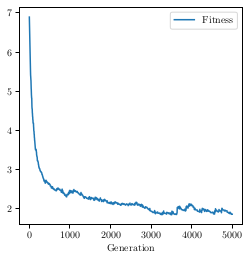

In [2098]:
df = pd.DataFrame()

df['Generation'] = pd.DataFrame(list(range(len(gb))))
df['Fitness'] = pd.DataFrame(gb)

fig = df.plot(x="Generation", y="Fitness", figsize=(4, 4) if save else (7, 7)).get_figure()
if save:
    fig.savefig(f'./pictures/{tsp_path}-fitness-{pc}-{gc}.pgf')


In [2099]:
colors = ['b', 'g', 'r', 'c', 'm', 'y']


def plot_route(route: np.ndarray, trail):
    cities = pd.DataFrame(g.cities, columns=['index', 'x', 'y'])
    p1 = cities.plot.scatter(x='x', y='y', figsize=(4, 4) if save else (7, 7))

    plt.plot([cities['x'][0], cities['x'][route[0]]],
             [cities['y'][0], cities['y'][route[0]]], 'bo--')
    for i in range(0, len(route) - 1):
        plt.plot([cities['x'][route[i]], cities['x'][route[i + 1]]],
                 [cities['y'][route[i]], cities['y'][route[i + 1]]], f'{g.rng.choice(colors)}o-')
    plt.show()
    if save:
        plt.savefig(f'./pictures/{tsp_path}-{trail}.pgf')



C:\Users\k\AppData\Local\Temp\ipykernel_8896\2455923853.py:13: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\k\AppData\Local\Temp\ipykernel_8896\2455923853.py:13: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


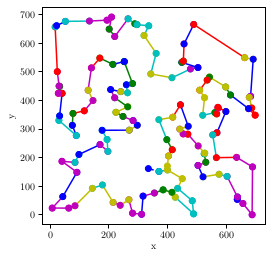

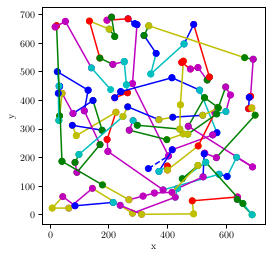

In [2100]:
plot_route(g.opt_route, trail='opt')
plot_route(br, trail=f'{pc}-{gc}-br')
